In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from scipy.io import mmread
from scipy.sparse import csr_matrix

import sys
import os
from os import listdir

In [3]:
def viz(
    adata0, 
    genes,
    basis="X_pca",
    color=['treatment_time'],
    size=40, alpha=.6,
    legend_loc='right margin',
    palette='viridis',
    legend_fontsize=8, 
    legend_fontoutline=10,
    title='',
    components='1,2',
    return_data = False,
    bora = 'after'
):
    adata = adata0.copy()
    
    if bora=='before':
        adata = adata[:, genes]
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    if bora=='after':
        adata = adata[:, genes]
    
    sc.tl.pca(adata, svd_solver='arpack')

    sc.pl.embedding(
        adata,
        basis=basis,
        color=color,
        size=size, 
        alpha=alpha,
        legend_loc=legend_loc,
        palette=palette,
        legend_fontsize=legend_fontsize, 
        legend_fontoutline=legend_fontoutline,
        show=True, 
        title=title,
        components=components
    )
    if return_data:
        return adata
    
def process_for_benchmarking(adata, layer, n_neighbors=50):
    X = adata.layers[layer]
    X = X.A if issparse(X) else X
    
    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)
    adata.obsm['X_pca'] = Xpca
    adata.varm['precomputed_PCs'] = pca.components_
    
    if n_neighbors > 0:
        cnx = vt.pp.connectivities(total=X, n_neighbors=n_neighbors)
        Xsmooth = vt.pp.moments(X=X, cnx=cnx, n_neighbors=n_neighbors)
        Xlogsmooth = np.log1p(Xsmooth)
        pca = PCA()
        Xpcasmooth = pca.fit_transform(Xlogsmooth)
        adata.obsm['X_pca_smooth'] = Xpcasmooth
    else:
        adata.obsm['X_pca_smooth'] = Xpca
    return adata

# 1. sciFATE

In [4]:
scif_path = '../data/other_metlab/scifate/'

cell_meta = pd.read_csv(f'{scif_path}/GSM3770930_A549_cell_annotate.txt', index_col='sample')
new_cell_meta = pd.read_csv(f'{scif_path}/GSM3770930_A549_cell_annotate_newly_synthesised.txt', index_col='sample')

cell_meta['new_exon_reads'] = new_cell_meta['all_exon']
cell_meta['new_intron_reads'] = new_cell_meta['all_intron']
cell_meta['new_all_reads'] = new_cell_meta['all_reads']

gene_meta = pd.read_csv(f'{scif_path}/GSM3770930_A549_gene_annotate.txt', index_col='gene_short_name')

old_count = mmread(f'{scif_path}/GSM3770930_A549_gene_count.txt').T
new_count = mmread(f'{scif_path}/GSM3770930_A549_gene_count_newly_synthesised.txt').T

scif_data = ann.AnnData(X=csr_matrix(old_count), obs=cell_meta, var=gene_meta,
                       layers={'old':csr_matrix(old_count), 'new':csr_matrix(new_count)})

scif_data.var_names_make_unique()

scif_data.layers['total'] = scif_data.layers['old'] + scif_data.layers['new']

scif_data.write_loom(f'{scif_path}/scifate_A549_data.loom')



In [5]:
scif_data.layers['total'] = scif_data.layers['old'] + scif_data.layers['new']
scif_data.write_loom(f'{scif_path}/scifate_A549_data.loom')

In [6]:
adata = sc.read_loom(f'{scif_path}/scifate_A549_data.loom')
adata.var = adata.var.set_index('gene_short_name')

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['label_rate'] = adata.layers['new'].sum(1) / adata.layers['total'].sum(1)

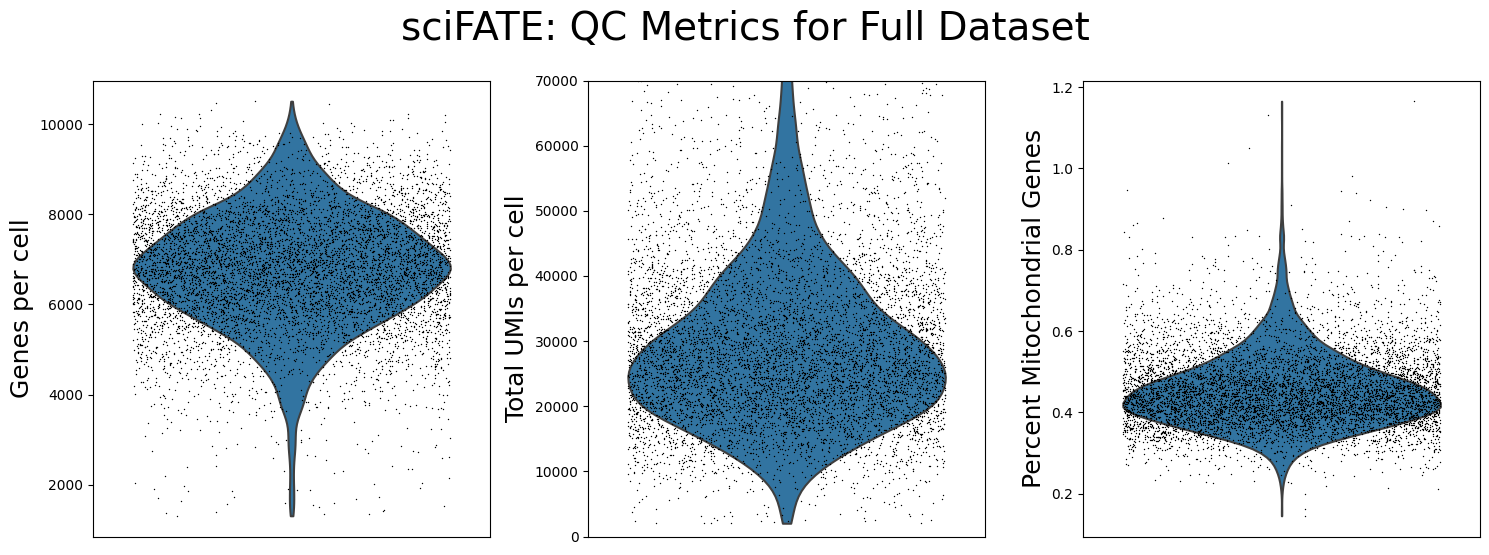

In [8]:
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
sc.pl.violin(adata, ['n_genes_by_counts'], ax=ax1, show=False, jitter=0.4,stripplot=True)
ax1.set_ylabel("Genes per cell", fontsize=18)
ax1.set_xticks([])
sc.pl.violin(adata, ['total_counts'], ax=ax2, show=False, jitter=0.4,stripplot=True)
ax2.set_ylim((0,70000))
ax2.set_ylabel("Total UMIs per cell", fontsize=18)
ax2.set_xticks([])
sc.pl.violin(adata, ['pct_counts_mt'], ax=ax3, show=False, jitter=0.4,stripplot=True)
ax3.set_ylabel("Percent Mitochondrial Genes", fontsize=18)
ax3.set_xticks([])
plt.tight_layout()
plt.suptitle("sciFATE: QC Metrics for Full Dataset", y=1.1, fontsize=28)
plt.show()

In [9]:
subset = adata.copy()

subset=subset[subset.obs.total_counts > np.percentile(adata.obs.total_counts, 10)] 
subset=subset[subset.obs.total_counts < np.percentile(adata.obs.total_counts, 90)] 

subset=subset[subset.obs.n_genes_by_counts > np.percentile(adata.obs.n_genes_by_counts, 10)] 
subset=subset[subset.obs.n_genes_by_counts < np.percentile(adata.obs.n_genes_by_counts, 90)] 

subset=subset[subset.obs.label_rate > np.percentile(adata.obs.label_rate, 10)]
subset=subset[subset.obs.label_rate < np.percentile(adata.obs.label_rate, 90)] 
subset=subset[subset.obs.pct_counts_mt < np.percentile(adata.obs.pct_counts_mt, 90)] 

In [11]:
scif = subset.copy()
sc.pp.filter_genes(scif, min_counts=10)


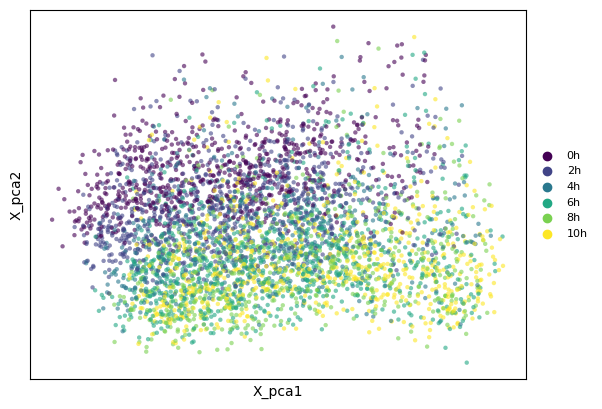

In [12]:
genes = vt.pp.select_genes(
    scif,
    n_variable_genes=3000,
)

viz(scif, genes)

The trajectory across timepoints here isn't so clear.
what if we select genes that vary only across timepoints?

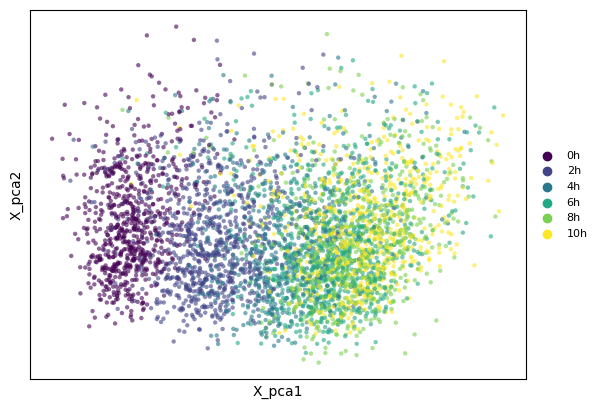

In [13]:
genes = vt.pp.select_genes(
    scif,
    n_variable_genes=3000,
    n_focal_genes=1000,
    focal_obs='treatment_time',
)

viz(scif, genes)

This looks a little better insofar that the principal component of variation is now timepoint.

In [17]:
adata = subset.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
    n_focal_genes=1000,
    focal_obs='treatment_time',
)

adata = vt.pp.size_normalize(
    adata, 
    genes=genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'{scif_path}/scifate_benchmark.h5ad')

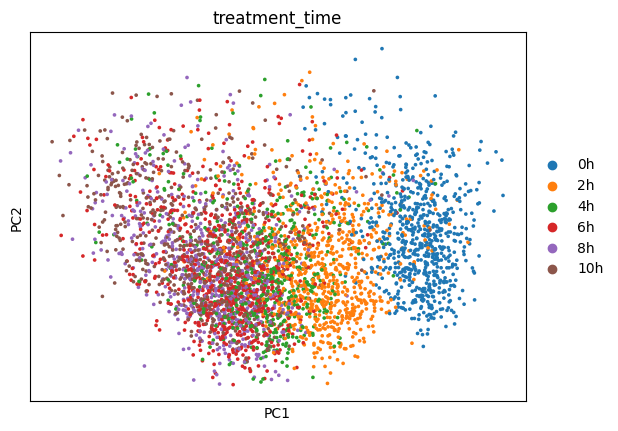

In [18]:
sc.pl.pca(adata, color='treatment_time')

## scEU-seq: 

no timecourse information.

In [43]:
# # rpe1

# sceu_path = '../data/other_metlab/sceuseq/'

# sceu_LS = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_RPE1_labeled_splicedUMI.csv',index_col='Gene_Id')
# sceu_LU = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_RPE1_labeled_unsplicedUMI.csv',index_col='Gene_Id')
# sceu_US = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_RPE1_unlabeled_splicedUMI.csv',index_col='Gene_Id')
# sceu_UU = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_RPE1_unlabeled_unsplicedUMI.csv',index_col='Gene_Id')
# metadata = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_RPE1_metadata.csv', index_col='Cell_Id').T

# genedata = pd.read_csv(f'{sceu_path}/sceu_genes.csv',index_col='symbol').drop(['Unnamed: 0'],axis=1)
# new_index = []
# for n, i in enumerate(genedata.index):
#     if type(i)==float:
#         new_index.append('NULL_{0}'.format(n))
#     else:
#         new_index.append(i)
        
# sceu_new = (np.array(sceu_LS) + np.array(sceu_LU)).T
# sceu_old = (np.array(sceu_US) + np.array(sceu_UU)).T
# sceu_tot = sceu_new + sceu_old

# genedata['gene_symbol'] = new_index
# genedata = genedata.set_index('gene_symbol')

# rpe1_data = ann.AnnData(X=sceu_tot, obs=metadata, var=genedata,
#                        layers={'old':sceu_old, 'new':sceu_new, 'total':sceu_tot})
# rpe1_data.var_names_make_unique()

# rpe1_data.write_loom(f'{sceu_path}/sceu_rpe1_data.loom')

# # organoid
# sceu_LS = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_organoids_labeled_splicedUMI.csv', index_col='NAME')
# sceu_LU = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_organoids_labeled_unsplicedUMI.csv', index_col='NAME')
# sceu_US = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_organoids_unlabeled_splicedUMI.csv', index_col='NAME')
# sceu_UU = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_organoids_unlabeled_unsplicedUMI.csv', index_col='NAME')

# metadata = pd.read_csv(f'{sceu_path}/GSE128365_SupplementaryData_organoids_cell_metadata.csv',index_col='cell_id').T
# genedata = pd.DataFrame({'Gene_ID':sceu_LS.ID})

# sceu_new = (np.array(sceu_LS.drop(['ID'],axis=1)) + np.array(sceu_LU.drop(['ID'],axis=1))).T
# sceu_old = (np.array(sceu_US.drop(['ID'],axis=1)) + np.array(sceu_UU.drop(['ID'],axis=1))).T
# sceu_tot = sceu_old + sceu_new

# org_data = ann.AnnData(X=sceu_tot, obs=metadata, var=genedata,
#                        layers={'old':sceu_old, 'new':sceu_new, 'total':sceu_tot})

# org_data.var_names_make_unique()



# scNT-seq

In [19]:
scnt_path = '../data/other_metlab/scntseq/'

In [20]:
[a for a in listdir(scnt_path) if 'Kcl' in a]

['GSM4512672_Neu-Kcl-60min_C.txt',
 'GSM4512671_Neu-Kcl-30min_C.txt',
 'GSM4512672_Neu-Kcl-60min_T.txt',
 'GSM4512670_Neu-Kcl-15min_T.txt',
 'GSM4512670_Neu-Kcl-15min_C.txt',
 'GSM4512673_Neu-Kcl-120min_T.txt',
 'GSM4512669_Neu-Kcl-0min_C.txt',
 'GSM4512673_Neu-Kcl-120min_C.txt',
 'GSM4512671_Neu-Kcl-30min_T.txt',
 'GSM4512669_Neu-Kcl-0min_T.txt']

In [21]:
files = [a for a in listdir(scnt_path) if 'Kcl' in a]

In [22]:
new_files = np.sort([a for a in files if a.split('_')[-1] == 'C.txt'])
old_files = np.sort([a for a in files if a.split('_')[-1] == 'T.txt'])

In [23]:
new_dat = pd.concat([pd.read_csv(scnt_path+f, sep='\t') for f in tqdm(new_files)], axis=1)

100%|██████████| 5/5 [01:27<00:00, 17.58s/it]


In [24]:
old_dat = pd.concat([pd.read_csv(scnt_path+f, sep='\t') for f in tqdm(old_files)], axis=1)

100%|██████████| 5/5 [01:28<00:00, 17.65s/it]


In [25]:
np.mean(old_dat.columns == new_dat.columns)

1.0

In [26]:
np.mean(old_dat.index == new_dat.index)

1.0

In [27]:
obs = pd.DataFrame({'Cell_ID':old_dat.columns})
obs = obs.set_index('Cell_ID')

var = pd.DataFrame({'Gene':old_dat.index})
var = var.set_index('Gene')

new = new_dat.T.to_numpy()
old = old_dat.T.to_numpy()
tot = new + old

nt_data = ann.AnnData(X=tot, obs=obs, var=var,
                      layers={'old':old, 'new':new, 'total':tot})
nt_data.var_names_make_unique()

In [28]:
nt_data.write_loom(f'{scnt_path}/scnt_data.loom')

In [29]:
adata = sc.read_loom(f'{scnt_path}/scnt_data.loom')

In [30]:
adata.var['mt'] = adata.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.obs['label_rate'] = adata.layers['new'].sum(1) / adata.layers['total'].sum(1)

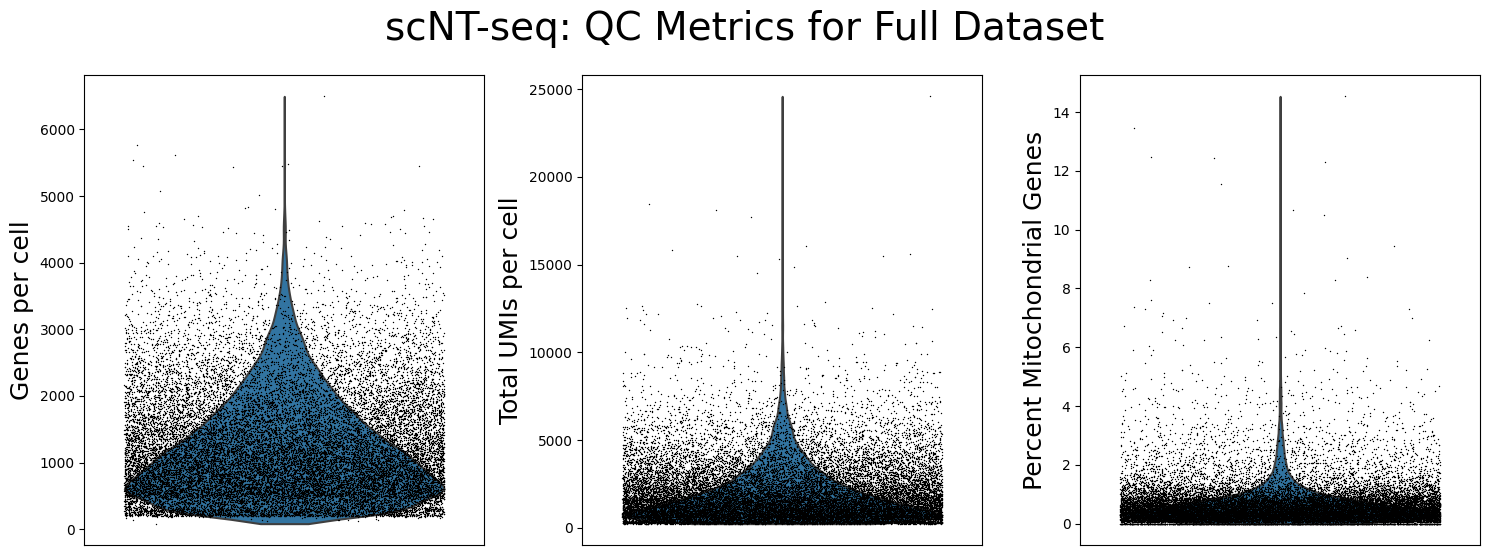

In [31]:
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
sc.pl.violin(adata, ['n_genes_by_counts'], ax=ax1, show=False, jitter=0.4,stripplot=True)
ax1.set_ylabel("Genes per cell", fontsize=18)
ax1.set_xticks([])
sc.pl.violin(adata, ['total_counts'], ax=ax2, show=False, jitter=0.4,stripplot=True)
ax2.set_ylabel("Total UMIs per cell", fontsize=18)
ax2.set_xticks([])
sc.pl.violin(adata, ['pct_counts_mt'], ax=ax3, show=False, jitter=0.4,stripplot=True)
ax3.set_ylabel("Percent Mitochondrial Genes", fontsize=18)
ax3.set_xticks([])
plt.tight_layout()
plt.suptitle("scNT-seq: QC Metrics for Full Dataset", y=1.1, fontsize=28)
plt.show()

In [32]:
subset = adata.copy()

subset=subset[subset.obs.total_counts > np.percentile(adata.obs.total_counts, 10)] 
subset=subset[subset.obs.total_counts < np.percentile(adata.obs.total_counts, 90)] 

subset=subset[subset.obs.n_genes_by_counts > np.percentile(adata.obs.n_genes_by_counts, 10)] 
subset=subset[subset.obs.n_genes_by_counts < np.percentile(adata.obs.n_genes_by_counts, 90)] 

subset=subset[subset.obs.label_rate > np.percentile(adata.obs.label_rate, 10)] 
subset=subset[subset.obs.label_rate < np.percentile(adata.obs.label_rate, 90)] 

subset=subset[subset.obs.pct_counts_mt < np.percentile(adata.obs.pct_counts_mt, 90)] 

In [33]:
subset.obs['KCl_time'] = [int(a.split("_")[0].replace("-Kcl","")[8:-7].replace('min','').replace("only",'0')) for a in subset.obs.Cell_ID]

In [34]:
scnt = subset.copy()
sc.pp.filter_genes(scnt, min_counts=10)

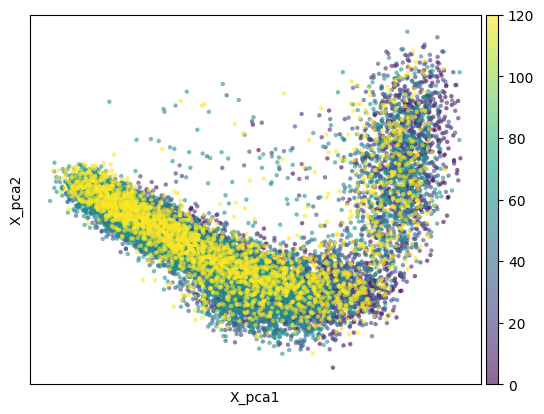

In [35]:
genes = vt.pp.select_genes(
    scnt,
    n_variable_genes=3000,
)

viz(scnt, genes, color='KCl_time', bora='before')

Here we see that KCl time is by no means the major source of variation in the data. Can we focus gene selection towards this temporal dimension?

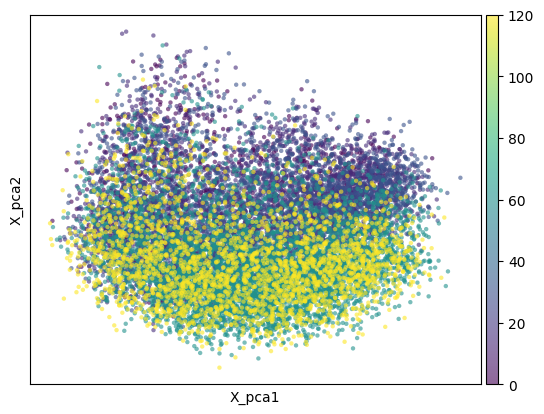

In [36]:
genes = vt.pp.select_genes(
    scnt,
    n_variable_genes=3000,
    n_focal_genes=1000,
    focal_obs='KCl_time',
)

vdata = viz(scnt, genes, color='KCl_time', return_data=True, bora='before')

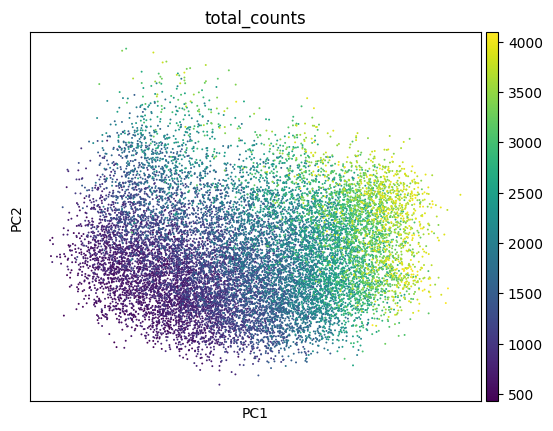

In [37]:
sc.pl.pca(vdata, color='total_counts')

The temporal ordering is a bit more evident, but there is a very evident total count bias that is difficult to remove.

In [39]:
adata = subset.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
    n_focal_genes=1000,
    focal_obs='KCl_time',
)

adata = vt.pp.size_normalize(
    adata, 
    genes=genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'{scnt_path}/scntseq_benchmark.h5ad')

# 5. Well-TEMP-seq

In [40]:
wt_path = '../data/other_metlab/welltempseq/'

datas = []
for fn, tp in zip(['GSM5834056','GSM5834057','GSM5834058','GSM5834059'],['0d','1d','2d','3d']):
    print(f"{fn}_{tp}")
    d = pd.read_csv(wt_path+f"{fn}_HCT116_{tp}_TC_matrix.txt", sep='\t')
    old_genes = [g for g in d.index if '--T' in g]
    new_genes = [g for g in d.index if '--C' in g]
    
    old_data = d.loc[old_genes,:].T
    new_data = d.loc[new_genes,:].T

    old_data.columns = [i.replace("--T",'') for i in old_data.columns]
    new_data.columns = [i.replace("--C",'') for i in new_data.columns]

    genes_in_old = old_data.columns
    genes_in_new = new_data.columns
    
    genes_not_in_old = genes_in_new.difference(genes_in_old)
    genes_not_in_new = genes_in_old.difference(genes_in_new)
    
    for gene in tqdm(genes_not_in_old):
        old_data[gene] = 0

    for gene in tqdm(genes_not_in_new):
        new_data[gene] = 0

    new_data = new_data.reindex(columns=sorted(new_data.columns))
    old_data = old_data.reindex(columns=sorted(old_data.columns))
    
    assert new_data.shape == old_data.shape
    assert np.mean(new_data.columns == old_data.columns) == 1.0

    obs = pd.DataFrame({'Cell_ID':old_data.index})
    obs = obs.set_index('Cell_ID')
    obs['timepoint'] = tp.replace("d","")

    var = pd.DataFrame({'Gene':old_data.columns})
    var = var.set_index('Gene')

    new = csr_matrix(np.nan_to_num(new_data.to_numpy()))
    old = csr_matrix(np.nan_to_num(old_data.to_numpy()))
    tot = csr_matrix(new + old)

    wt_data = ann.AnnData(X=np.nan_to_num(tot), obs=obs, var=var,
                          layers={'old':np.nan_to_num(old), 'new':np.nan_to_num(new), 'total':np.nan_to_num(tot)})

    wt_data.var_names_make_unique()
    
    datas.append(wt_data)

GSM5834056_0d


100%|██████████| 4037/4037 [00:06<00:00, 669.82it/s]


GSM5834057_1d


100%|██████████| 3872/3872 [00:06<00:00, 569.08it/s]


GSM5834058_2d


100%|██████████| 4130/4130 [00:07<00:00, 554.69it/s]


GSM5834059_3d


100%|██████████| 4014/4014 [00:07<00:00, 528.81it/s]


In [41]:
datas

[AnnData object with n_obs × n_vars = 4000 × 23233
     obs: 'timepoint'
     layers: 'old', 'new', 'total',
 AnnData object with n_obs × n_vars = 4000 × 24226
     obs: 'timepoint'
     layers: 'old', 'new', 'total',
 AnnData object with n_obs × n_vars = 4000 × 25465
     obs: 'timepoint'
     layers: 'old', 'new', 'total',
 AnnData object with n_obs × n_vars = 4000 × 25641
     obs: 'timepoint'
     layers: 'old', 'new', 'total']

In [42]:
adata = ann.concat(datas, join='outer', fill_value=0)

In [43]:
adata.var['mt'] = adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.obs['label_rate'] = adata.layers['new'].sum(1) / adata.layers['total'].sum(1)

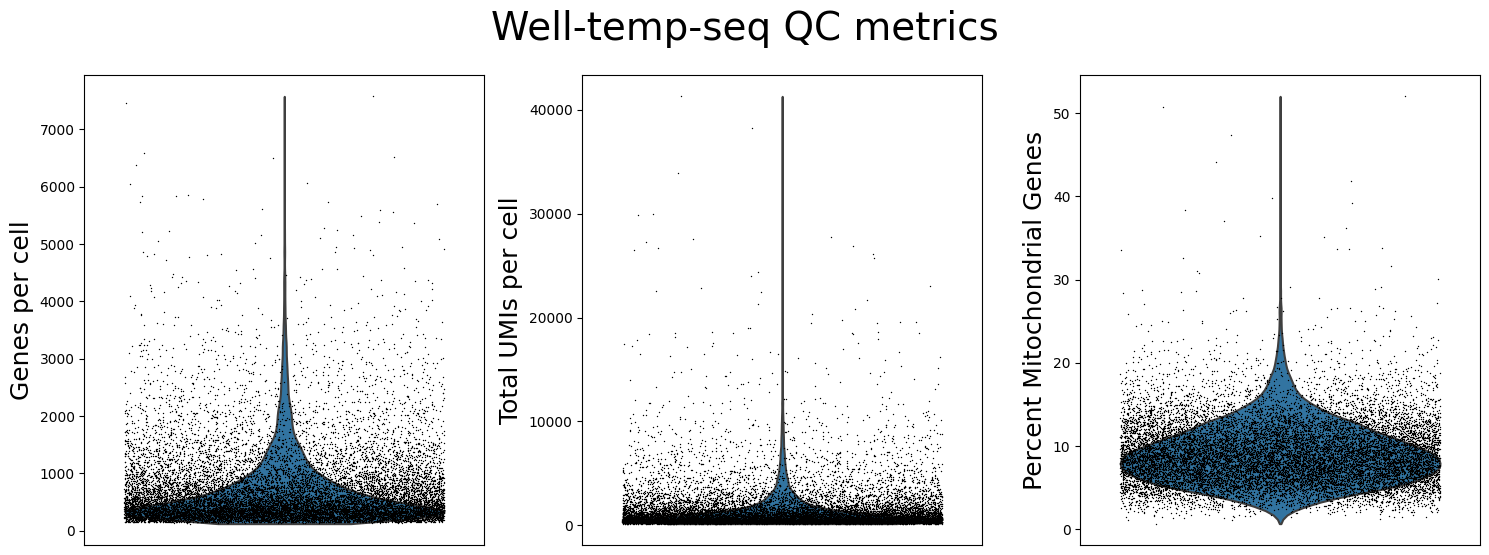

In [44]:
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1,3)
sc.pl.violin(adata, ['n_genes_by_counts'], ax=ax1, show=False, jitter=0.4,stripplot=True)
ax1.set_ylabel("Genes per cell", fontsize=18)
ax1.set_xticks([])
sc.pl.violin(adata, ['total_counts'], ax=ax2, show=False, jitter=0.4,stripplot=True)
ax2.set_ylabel("Total UMIs per cell", fontsize=18)
ax2.set_xticks([])
sc.pl.violin(adata, ['pct_counts_mt'], ax=ax3, show=False, jitter=0.4,stripplot=True)
ax3.set_ylabel("Percent Mitochondrial Genes", fontsize=18)
ax3.set_xticks([])
plt.tight_layout()
plt.suptitle("Well-temp-seq QC metrics", y=1.1, fontsize=28)
plt.show()

In [48]:
subset = adata.copy()

subset=subset[subset.obs.total_counts > 1000] 
subset=subset[subset.obs.total_counts < np.percentile(adata.obs.total_counts, 90)] 

subset=subset[subset.obs.n_genes_by_counts > np.percentile(adata.obs.n_genes_by_counts, 10)] 
subset=subset[subset.obs.n_genes_by_counts < np.percentile(adata.obs.n_genes_by_counts, 90)] 

subset=subset[subset.obs.label_rate > np.percentile(adata.obs.label_rate, 10)]
subset=subset[subset.obs.label_rate < np.percentile(adata.obs.label_rate, 90)]

subset=subset[subset.obs.pct_counts_mt < np.percentile(adata.obs.pct_counts_mt, 90)] 

In [49]:
# subset.write_h5ad(f'{wt_path}/wt_data_processed.h5ad')

In [50]:
wts = subset.copy()
sc.pp.filter_genes(wts, min_counts=10)

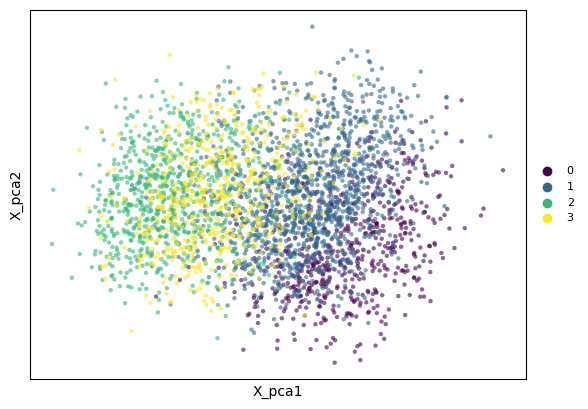

In [51]:
genes = vt.pp.select_genes(
    wts,
    n_variable_genes=3000,
)

viz(wts, genes, color='timepoint', bora='before')

Timepoint stratification is clear, but still there is a major component of variation due to data quality.

In [54]:
adata = subset.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    wts,
    n_variable_genes=3000,
)

adata = vt.pp.size_normalize(
    adata, 
    genes=genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'{wt_path}/welltempseq_benchmark.h5ad')

# 6. scNT-seq2

In [34]:
adata = sc.read_h5ad('../data/other_metlab/scntseq2/GSE193517_HSC.h5ad')

In [42]:
adata

AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'umap_leiden', 'umap_louvain', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'umap_ori_ddhodge_div', 'umap_ori_ddhodge_potential', 'curl_umap_ori', 'divergence_umap_ori', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curvature_umap_ori', 'acceleration_umap_ori', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'curvature_umap', 'curv_leiden', 'curv_louvain', 'SPI1->

This data has already been heavily processed, so may not be appropriate for benchmarking.